In [1]:
import os
os.chdir('/home/ssobti/projects/mir_tud/packages/ciberatac-main/src/mave')
import pandas as pd
import numpy as np
import scanpy as sc
import itertools
import pickle
import shelve

In [2]:
weighting_scheme = 'temp_shap'
weights = [100, 0.001, 1, 100]

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

2023-02-03 20:27:41.462302: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.2 scikit-learn==1.2.0 statsmodels==0.13.5 pynndescent==0.5.8


In [4]:
adata = sc.read('/home/ssobti/projects/mir_tud/110222_filtered_data/miR.concat.raw.adata_gex.guide_assigned.h5')

Only considering the two last: ['.guide_assigned', '.h5'].
Only considering the two last: ['.guide_assigned', '.h5'].


In [5]:
### feed in raw matrix (adata.X) into VAE with filter out cells with low # genes and genes expressed in low # of cells
adata.var_names_make_unique()

In [6]:
adata

AnnData object with n_obs × n_vars = 30035 × 36601
    obs: 'sample', 'barcode', 'guide', 'lor', 'pvalue', 'adj_pvalue', 'max_umi', 'n_umi', 'm_umi', 'v_umi', 'log_max_umi', 'log_n_umi', 'log_m_umi'
    var: 'feature_type'

normalizing counts per cell
    finished (0:00:01)


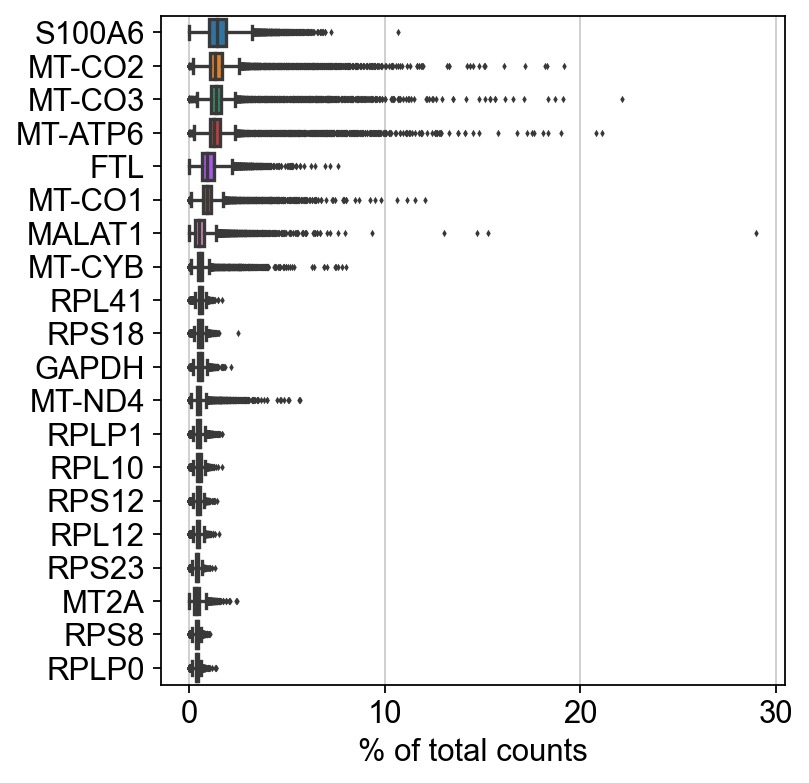

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 1 cells that have less than 200 genes expressed
filtered out 6345 genes that are detected in less than 3 cells


In [9]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

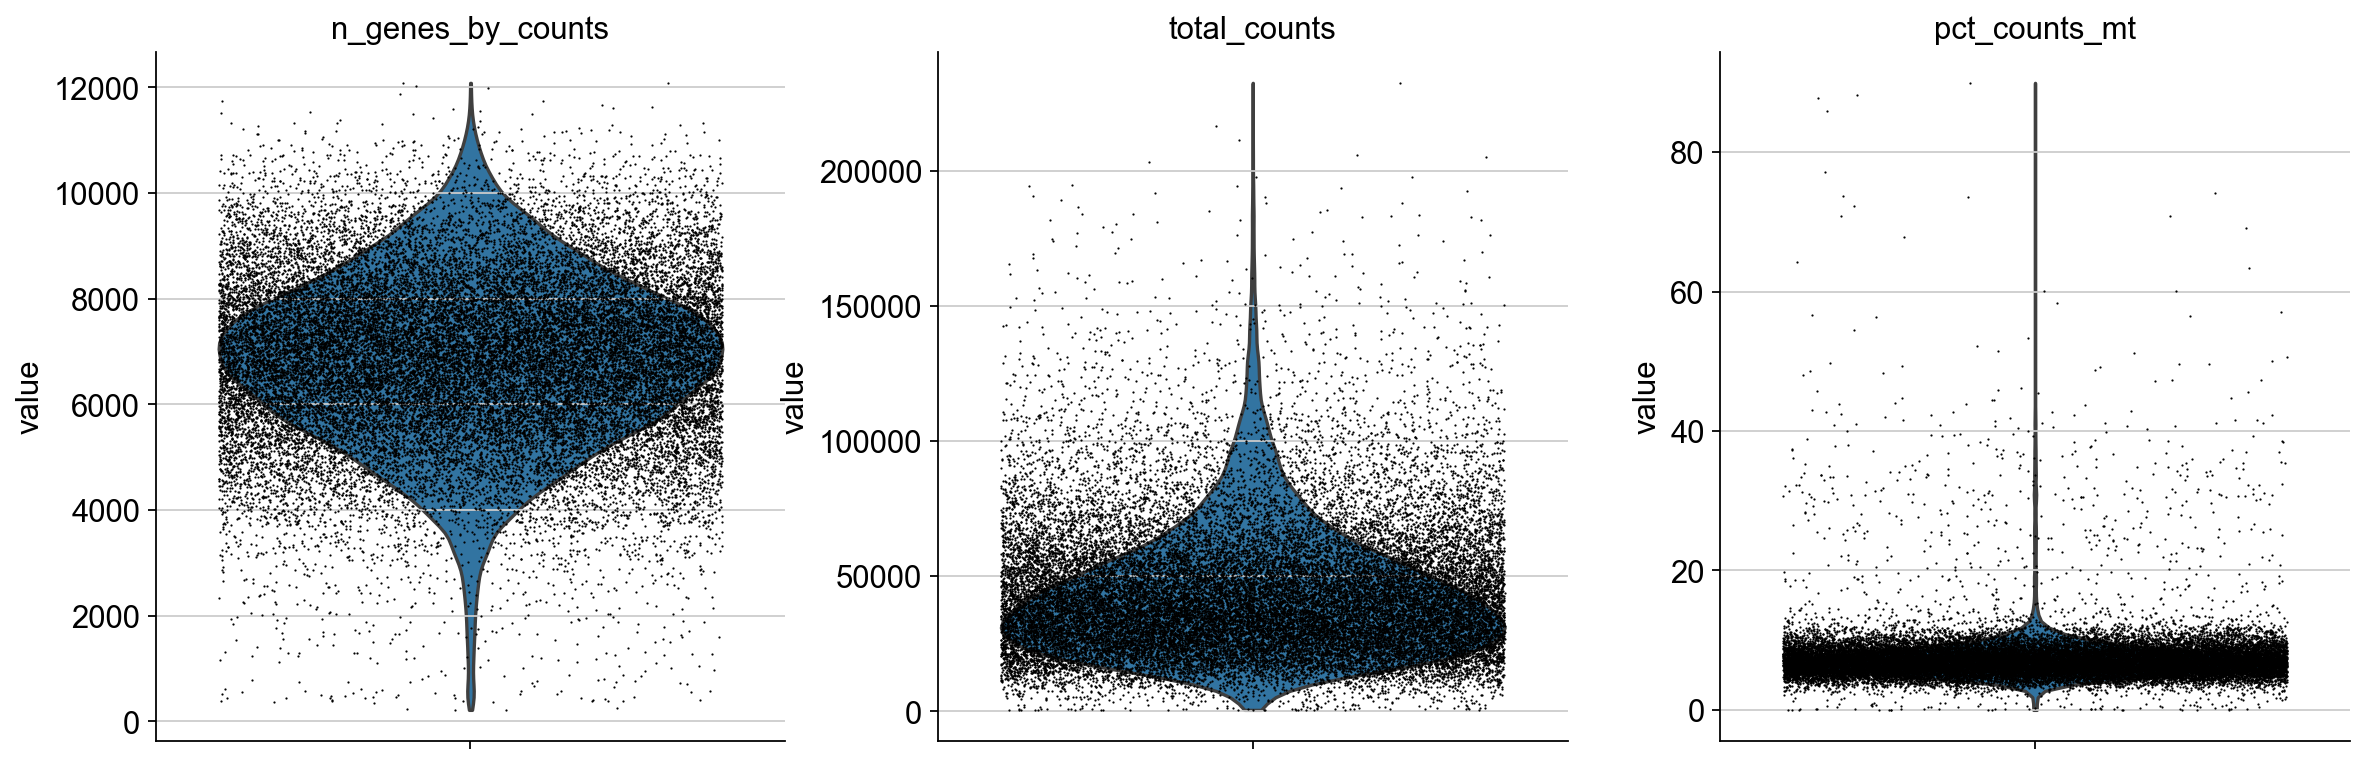

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

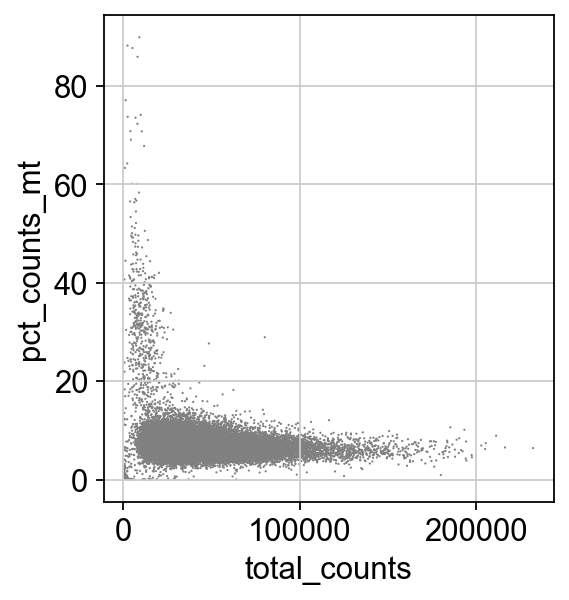

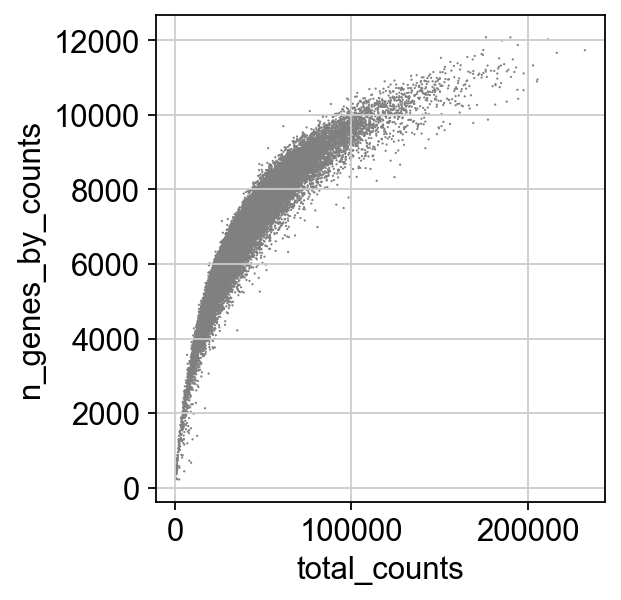

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [12]:
adata = adata[adata.obs.pct_counts_mt < 12, :]

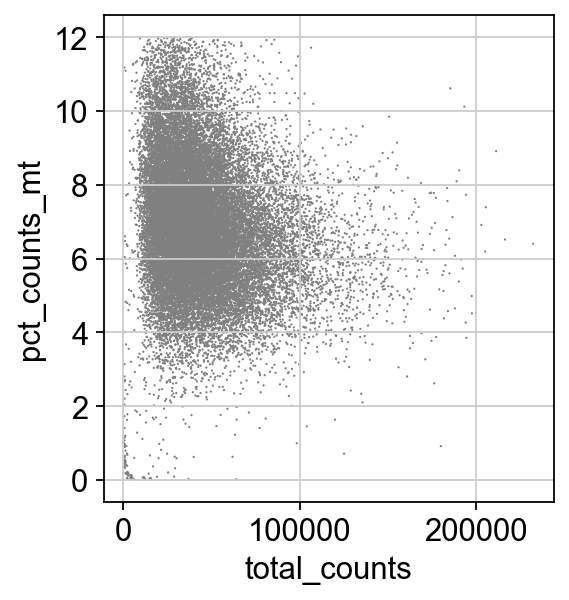

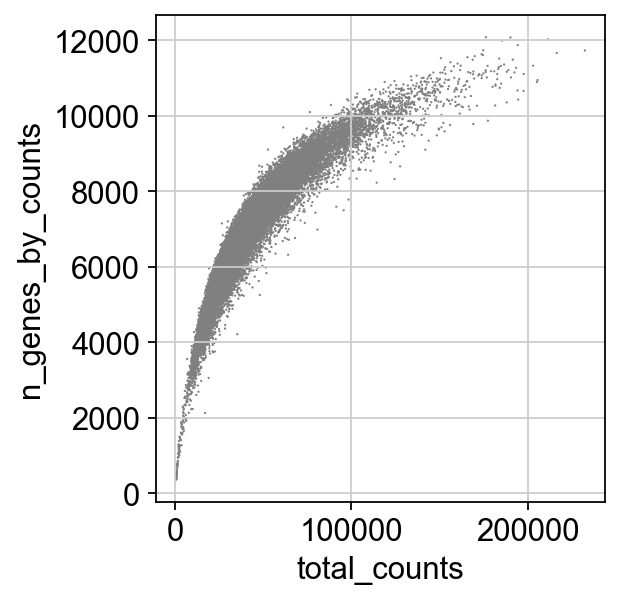

In [13]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [14]:
### remove ('hsa-miR-92a-3p', ['miR_1:TCACAAGTCGGCATAT-1']) from adata
cells_to_keep = [cell for cell in adata.obs.index.to_list() if cell != 'miR_1:TCACAAGTCGGCATAT-1']
adata = adata[cells_to_keep,:]

In [15]:
adata.obs

,sample,barcode,guide,lor,pvalue,adj_pvalue,max_umi,n_umi,m_umi,v_umi,log_max_umi,log_n_umi,log_m_umi,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt
miR_1:AAACCCAAGGAGAGGC-1,miR_1,AAACCCAAGGAGAGGC,hsa-miR-203a-3p,5.453121,2.983000e-159,3.010603e-152,67.0,78.0,0.196474,11.324937,1.826075,1.892095,-0.706696,6001,6001,33957.0,2912.0,8.575551
miR_1:AAACCCAAGGTAAACT-1,miR_1,AAACCCAAGGTAAACT,hsa-miR-93-3p,6.012001,3.907611e-225,3.943769e-218,97.0,108.0,0.272040,23.713686,1.986772,2.033424,-0.565367,6871,6870,31930.0,2091.0,6.548700
miR_1:AAACCCACAACGATCT-1,miR_1,AAACCCACAACGATCT,hsa-miR-130b-3p,5.864701,3.299362e-202,3.329893e-195,89.0,113.0,0.284635,19.981910,1.949390,2.053078,-0.545712,7448,7448,42786.0,3784.0,8.844014
miR_1:AAACCCACACGATTCA-1,miR_1,AAACCCACACGATTCA,TuD_NC_18,5.859895,2.574602e-201,2.598426e-194,96.0,114.0,0.287154,23.235516,1.982271,2.056905,-0.541886,8043,8042,58540.0,5896.0,10.071746
miR_1:AAACCCACAGTCAACT-1,miR_1,AAACCCACAGTCAACT,hsa-miR-147b-5p,5.632808,3.564463e-178,3.597446e-171,71.0,86.0,0.216625,12.725683,1.851258,1.934498,-0.664292,6582,6582,31581.0,2431.0,7.697667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
miR_3:TTTGGTTTCGGACTTA-1,miR_3,TTTGGTTTCGGACTTA,hsa-miR-616-5p,3.885564,8.005527e-277,6.410418e-270,129.0,237.0,0.596977,44.983627,2.110590,2.374748,-0.224042,5525,5525,25937.0,2381.0,9.179936
miR_3:TTTGTTGCACGCGTGT-1,miR_3,TTTGTTGCACGCGTGT,hsa-miR-361-5p,0.506602,8.834341e-07,1.000000e+00,2.0,12.0,0.030227,0.034438,0.301030,1.079181,-1.519609,8828,8828,82117.0,6274.0,7.640318
miR_3:TTTGTTGCATAGATCC-1,miR_3,TTTGTTGCATAGATCC,hsa-miR-548o-3p,6.603449,5.795787e-306,4.640971e-299,126.0,159.0,0.400504,40.028586,2.100371,2.201397,-0.397393,6431,6431,34834.0,2480.0,7.119481
miR_3:TTTGTTGGTCTAGTGT-1,miR_3,TTTGTTGGTCTAGTGT,hsa-miR-3940-5p,2.402414,5.349572e-125,4.283664e-118,58.0,110.0,0.277078,9.251317,1.763428,2.041393,-0.557398,5103,5103,22318.0,1970.0,8.826956


In [16]:
### making all 20 control guides the same annotation
meta = adata.obs
meta = meta.astype({'guide':'string'})
meta.loc[meta.loc[:,'guide'].str.startswith('TuD_NC'), 'guide'] = 'TuD_NC'
meta = meta.astype({'guide':'category'})
adata.obs = meta
meta.dtypes

sample               category
barcode              category
guide                category
lor                   float64
pvalue                float64
adj_pvalue            float64
max_umi               float64
n_umi                 float64
m_umi                 float64
v_umi                 float64
log_max_umi           float64
log_n_umi             float64
log_m_umi             float64
n_genes                 int64
n_genes_by_counts       int32
total_counts          float32
total_counts_mt       float32
pct_counts_mt         float32
dtype: object

In [17]:
### pertubation annotation to add to each cell
one_hot_df = pd.get_dummies(adata.obs["guide"])

In [18]:
one_hot_df

,TuD_NC,hsa-let-7a-2-3p,hsa-let-7a-5p,hsa-let-7b-3p,hsa-let-7d-3p,hsa-let-7f-2-3p,hsa-let-7i-3p,hsa-let-7i-5p,hsa-miR-100-3p,hsa-miR-100-5p,...,hsa-miR-940,hsa-miR-941,hsa-miR-942-3p,hsa-miR-942-5p,hsa-miR-95-3p,hsa-miR-96-5p,hsa-miR-98-3p,hsa-miR-9903,hsa-miR-99b-3p,hsa-miR-99b-5p
miR_1:AAACCCAAGGAGAGGC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
miR_1:AAACCCAAGGTAAACT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
miR_1:AAACCCACAACGATCT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
miR_1:AAACCCACACGATTCA-1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
miR_1:AAACCCACAGTCAACT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
miR_3:TTTGGTTTCGGACTTA-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
miR_3:TTTGTTGCACGCGTGT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
miR_3:TTTGTTGCATAGATCC-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
miR_3:TTTGTTGGTCTAGTGT-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
## add the gene annotation for the first layer
## the first layer is connected to the second in a way such that reflects pathways
## RBP_gene_df is the gene connections (first layer) to TFs (second layer) gmt file

In [20]:
import scipy.sparse as sp_sparse
import tables
from itertools import chain
from model import loss_function
from model import VAE
import numpy as np
import os
import pandas as pd
import torch
from gseapy import read_gmt
from datetime import datetime


In [21]:
gmt_file = read_gmt('/home/ssobti/projects/mir_tud/uploaded_data/c3.all.v2022.1.Hs.symbols.gmt')

In [22]:
### creating a matrix that links gene sets (columns) to master regulators (rows) via 0/1 annotation
gmt_file = pd.Series(gmt_file).str.join('|')
gmt_file = gmt_file.str.get_dummies()
gmt_file

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZZEF1,ZZZ3
MIR153_5P,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MIR8485,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
MIR3662,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MIR607,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
MIR616_5P,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E2F1_Q4_01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E2F1_Q6_01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
KTGGYRSGAA_UNKNOWN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RRCCGTTA_UNKNOWN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
## remove genes not in intersection bw expression matrix and gene_set annotation df
a = set(gmt_file.columns.to_list())
b = set(adata.var.index.to_list())

intersecting_genes = list(a.intersection(b))
print('Genes in annotated gene sets', len(a))
print('Genes in expression matrix', len(b))
print('Union', len(a.union(b)))
print('Intersecting genes kept', len(a.intersection(b)))

adata = adata[:, intersecting_genes]
gmt_file = gmt_file.loc[:, intersecting_genes]

Genes in annotated gene sets 27990
Genes in expression matrix 30256
Union 39173
Intersecting genes kept 19073


In [24]:
gmtmat_df = gmt_file.transpose()
gmtmat_df

,MIR153_5P,MIR8485,MIR3662,MIR607,MIR616_5P,MIR371B_5P,MIR373_5P,MIR6867_5P,MIR12136,MIR548AJ_3P_MIR548X_3P,...,E2F1DP1RB_01,E2F_Q3_01,E2F_Q4_01,E2F_Q6_01,E2F1_Q3_01,E2F1_Q4_01,E2F1_Q6_01,KTGGYRSGAA_UNKNOWN,RRCCGTTA_UNKNOWN,SGCGSSAAA_E2F1DP2_01
RHD,1,0,0,0,1,1,1,0,0,0,...,1,1,0,0,0,1,0,0,0,0
IL27RA,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DDX23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SYNGAP1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
DDO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PEX14,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TPST2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
STARD4-AS1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SOWAHC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
gmtmat = gmtmat_df.to_numpy()
gmtmat

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [26]:
device='cpu'

In [27]:
gmttensor = torch.from_numpy(
            np.transpose(gmtmat)).to(device).long()
gmttensor

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])

In [28]:
## this function tells you how many paramters are in a model
def get_n_params(model):
    pp = 0
    for p in list(model.parameters()):
        nn = 1
        for s in list(p.size()):
            nn = nn * s
        pp += nn
    return pp

# Twin Model

In [29]:
import random
samps=random.sample(list(adata.obs.guide.unique()),2)
samps

['hsa-miR-22-3p', 'hsa-miR-660-5p']

In [30]:
adata.obs.index

Index(['miR_1:AAACCCAAGGAGAGGC-1', 'miR_1:AAACCCAAGGTAAACT-1',
       'miR_1:AAACCCACAACGATCT-1', 'miR_1:AAACCCACACGATTCA-1',
       'miR_1:AAACCCACAGTCAACT-1', 'miR_1:AAACCCACATCTCATT-1',
       'miR_1:AAACCCACATGTCGTA-1', 'miR_1:AAACCCACATTATGCG-1',
       'miR_1:AAACCCAGTCTAATCG-1', 'miR_1:AAACCCAGTTAATCGC-1',
       ...
       'miR_3:TTTGGAGTCTTCACGC-1', 'miR_3:TTTGGTTAGGCGACAT-1',
       'miR_3:TTTGGTTCAACGACTT-1', 'miR_3:TTTGGTTCATAGCTGT-1',
       'miR_3:TTTGGTTTCCTTACCG-1', 'miR_3:TTTGGTTTCGGACTTA-1',
       'miR_3:TTTGTTGCACGCGTGT-1', 'miR_3:TTTGTTGCATAGATCC-1',
       'miR_3:TTTGTTGGTCTAGTGT-1', 'miR_3:TTTGTTGGTTTCCATT-1'],
      dtype='object', length=29147)

In [31]:
ct_cbc_dict = {}
cbc_ct_dict = {}
for ct in list(adata.obs.guide.unique()):
    ct_cbc_dict[ct] = adata.obs.query(f'guide==\"{ct}\"').index.tolist()
    for cbc in ct_cbc_dict[ct]:
        cbc_ct_dict[cbc] = ct
list(ct_cbc_dict.items())[1]

('hsa-miR-93-3p',
 ['miR_1:AAACCCAAGGTAAACT-1',
  'miR_1:AAGTACCGTATCAGCT-1',
  'miR_1:AAGTCGTGTGTCATTG-1',
  'miR_1:ACCTGTCGTGTGTGGA-1',
  'miR_1:ACGTAACTCTCCAAGA-1',
  'miR_1:ACGTACAGTGTGTCGC-1',
  'miR_1:ACTTCCGAGTGATCGG-1',
  'miR_1:AGGTTACTCCGATAAC-1',
  'miR_1:ATTTCACCAGCGAACA-1',
  'miR_1:CACATGAGTCGACTTA-1',
  'miR_1:CACATGATCCGCAACG-1',
  'miR_1:CAGATACCACTAAACC-1',
  'miR_1:CAGCACGTCCATCTGC-1',
  'miR_1:CATGCCTGTCGAGTGA-1',
  'miR_1:CGTAATGCACAATGTC-1',
  'miR_1:CGTGATAAGAGAGGGC-1',
  'miR_1:CTAACCCAGGTTGACG-1',
  'miR_1:CTCATGCAGTAAGCAT-1',
  'miR_1:GACCCAGAGCATCAAA-1',
  'miR_1:GACCCTTTCGCTATTT-1',
  'miR_1:GGATCTAGTGTATACC-1',
  'miR_1:GGCTTGGCATCCCACT-1',
  'miR_1:GGTGATTGTGGATACG-1',
  'miR_1:GGTTGTACATCCTCAC-1',
  'miR_1:GTGAGTTTCGTGGCGT-1',
  'miR_1:GTGCTTCCAATTTCTC-1',
  'miR_1:GTTTACTGTATAGCTC-1',
  'miR_1:GTTTGGATCCCTGTTG-1',
  'miR_1:TATGTTCGTATGAAGT-1',
  'miR_1:TATTGCTCAATCGCAT-1',
  'miR_1:TATTTCGCAGTTACCA-1',
  'miR_1:TCTACATGTTTACGTG-1',
  'miR_1:TGTTCCGCAATTG

In [32]:
list(cbc_ct_dict.items())[1]

('miR_1:AATGGCTAGCGAAACC-1', 'hsa-miR-203a-3p')

In [33]:
adata.X.toarray().shape

(29147, 19073)

In [34]:
adata.var.shape

(19073, 7)

In [35]:
## this converts the expression matrix to a dictionary 
## where each cell/row of matrix is now a 'key' with associated gene expression values

cbc_arr_dict = {}
for cbc, arr in zip(adata.obs.index.tolist(), adata.X.toarray()):
    cbc_arr_dict[cbc] = arr.copy()
list(cbc_arr_dict.items())[1]

('miR_1:AAACCCAAGGTAAACT-1',
 array([0., 0., 2., ..., 0., 0., 2.], dtype=float32))

In [36]:
## this converts the cell barcode to guide annotation df to a dictionary 
one_hot_dict = one_hot_df.T.to_dict(orient='list')
list(one_hot_dict.keys())[0]

'miR_1:AAACCCAAGGAGAGGC-1'

In [37]:
numlvs = 10
vae = VAE(adata.shape[1],  # num genes
              gmttensor, #gmttensor
              len(set(adata.obs["guide"])), #number of cell types
              0,  # batch
              0,  # labels
              gmtmat.shape[1],  # hiddensize
              numlvs)

n_params = get_n_params(vae)
print("VAE has {} parameters".format(n_params))
vae.to(device)

VAE has 355467811 parameters


VAE(
  (z_encoder): Encoder(
    (encoder): FCLayersEncoder(
      (fc_layers): Sequential(
        (Layer_0): Sequential(
          (0): CustomConnected()
          (1): BatchNorm1d(3725, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linear(in_features=3725, out_features=10, bias=True)
    (var_encoder): Linear(in_features=3725, out_features=10, bias=True)
  )
  (ctpred_linear): Linear(in_features=10, out_features=377, bias=True)
  (ctpred_activation): ReLU()
  (l_encoder): Encoder(
    (encoder): FCLayersEncoder(
      (fc_layers): Sequential(
        (Layer_0): Sequential(
          (0): CustomConnected()
          (1): BatchNorm1d(3725, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): None
          (3): ReLU()
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (mean_encoder): Linea

In [38]:
vae.load_state_dict(torch.load('/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/models/default_R100_K1_C1_T0.01_model.pt')['model'])

<All keys matched successfully>

In [2]:
#### LOADING SELECTED CELLS

filenm = '/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/selected_cells.out'
my_shelf = shelve.open(filenm)
for key in my_shelf:
    globals()[key]=my_shelf[key]
my_shelf.close()

In [3]:
len(barcds)

119

In [40]:
import shap
from torch import nn

class VaePredictor(nn.Module):
    def __init__(self, net):
        '''
        Assumes 0:idx_onc are oncRNA matrix
        Assumes idx_onc:idx_sm are smRNA matrix
        assumes idx_sm: are batch
        '''
        super().__init__()
        self.net = net
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # this assumes x has multiple types of data in it
        # and it's manually subsetting it here
        # you can remove reference to idx_onnc and idx_sm
        # if that's not the case
        outdict = self.net(x)
        ct_pred = self.softmax(outdict["ctpred"])
        return ct_pred


    def get_top_features(shap_values, feature_names, num_features=10):
        feature_order = np.argsort(np.sum(np.abs(shap_values[1]), axis=0))
        return np.array(feature_names)[feature_order[::-1][:num_features]]


    def get_top_10_features(shap_values, feature_names, num_features=10):
        feature_order = np.argsort(np.sum(np.abs(shap_values[1]), axis=0))
        return np.array(feature_names)[feature_order[::-1][:num_features]]


    def get_shap_values(net, dict_cur):
        dict_out = {}
        feature_names = dict_cur["genes"]
        expar_all = dict_cur["expar"]
        cell_guide = dict_cur["cell_guide"]
        tensor_expar_all = torch.from_numpy(expar_all).to(device).float()
        # max in memory; 128
        modelForShap = VaePredictor(net)
        shapExplainer = shap.DeepExplainer(modelForShap, tensor_expar_all)
        shap_values = shapExplainer.shap_values(tensor_expar_all)
        dict_out["Shap.values"] = shap_values
        dict_out["Input"] = expar_all
        dict_out["feature_names"] = feature_names
        dict_out["sample_names"] = cell_guide
        dict_out["shap_sums"] = np.sum(np.abs(shap_values[1]), axis=0)
        dict_out["plot_1"] = shap.summary_plot(shap_values, tensor_expar_all.detach().cpu().numpy(), feature_names)
        dict_out["plot_2"] = shap.summary_plot(shap_values[1], tensor_expar_all.detach().cpu().numpy(), feature_names)
        top_features = get_top_features(shap_values, feature_names, 10)
        dict_out["top_10"] = top_features
        del modelForShap, shapExplainer
        torch.cuda.empty_cache()
        return dict_out


    def add_uncertainty(perfdf, modelTrainObj, tune_dataloader, dict_tune, num_exps=25):
        modelTrainObj.net.train()
        pred_ar = np.zeros((num_exps, perfdf.shape[0], dict_tune["onehotar"].shape[1]))
        for i in range(num_exps):
            _, _, _, _, perfdf_temp = modelTrainObj.model_predict(tune_dataloader)
        for j in np.arange(pred_ar.shape[2]):
            pred_ar[i, :, j] = perfdf_temp.iloc[:, j]
        var_preds = np.var(pred_ar, axis=0)
        for j in np.arange(pred_ar.shape[2]):
            perfdf["Class.{}.predictionVariance".format(j)] = var_preds[:, j]
        perfdf["Max.Prediction.Variance"] = np.max(var_preds, axis=1)
        return perfdf


    def get_uncertainty_and_shap(modelpath, parampath, metadf):
        dict_cancer_codes = {0: 'Bladder',
        'Bladder': 0,
        1: 'Breast',
        'Breast': 1,
        2: 'Colorectal',
        'Colorectal': 2,
        3: 'Gastric',
        'Gastric': 3,
        4: 'Kidney',
        'Kidney': 4,
        5: 'Lung',
        'Lung': 5,
        6: 'Pancreas',
        'Pancreas': 6}
        modeldict = joblib.load(modelpath)
        dict_train = modeldict["dict_train"]
        print(dict_train["expar"].shape)
        dict_tune = modeldict["dict_tune"]
        print(dict_tune["expar"].shape)
        net, dict_params = get_net(
        dict_train, False, False, [10000, 1, 1, 0.1], 150)
        print(net)
        net.load_state_dict(torch.load(parampath))
        modelParamObj = ModelParams(
        MAXEPOCH=dict_params["epoch"], numlvs=int(dict_params["num_lvs"]),
        num_celltypes=dict_train["onehotar"].shape[1], MINIBATCH=128,
        use_observed_lib_size=False,
        use_size_factor_key=False,
        use_triplet_loss=True,
        use_augmentator=False,
        warmup=False, warmup_epoch=0,
        aug_method_names=[],
        predict_celltypes=True,
        use_external_tensor=True,
        loss_scalers=[10000, 1, 1, 0.1],
        l1=dict_params["l1"], l2=dict_params["l2"], l3=dict_params["l3"])
        dict_params = modelParamObj.print()
        expar = dict_train["expar"]
        DataObjTrain = OrionDataLoader(
        dict_train["expar"], dict_train["smrnamat"],
        dict_train["library_manual"], dict_train["batch_list"].reshape(-1, 1),
        dict_train["onehotar"], dict_train["expar"], dict_train["batch_list"])
        DataObjTune = OrionDataLoader(
        dict_tune["expar"], np.array(dict_tune["smrnamat"]),
        dict_tune["library_manual"], dict_tune["batch_list"].reshape(-1, 1),
        dict_tune["onehotar"], dict_tune["expar"])
        MINIBATCH = 128
        train_dataloader = DataLoader(DataObjTrain, batch_size=MINIBATCH, shuffle=False)
        tune_dataloader = DataLoader(DataObjTune, batch_size=MINIBATCH, shuffle=False)
        train_dataloader.oncmat = dict_train["expar"]
        train_dataloader.anchorObj = DataObjTrain.anchorObj
        tune_dataloader.oncmat = dict_tune["expar"]
        tune_dataloader.anchorObj = DataObjTune.anchorObj
        modelTrainObj = modelTrainer(net, expar, train_dataloader, tune_dataloader, dict_params)
        modelTrainObj.net.eval()
        reconst, mumat, sd2mat, dict_perf, perfdf = modelTrainObj.model_predict(tune_dataloader)
        perfdf.index = dict_tune["patient_names"]
        perfdf["patient.names"] = dict_tune["patient_names"]
        perfdf["Prediction.Label"] = [dict_cancer_codes[int(each)] for each in list(perfdf["Prediction"])]
        perfdf["Diagnosis"] = metadf.loc[perfdf.index, "cancer_diagnosis"]
        perfdf = add_uncertainty(perfdf, modelTrainObj, tune_dataloader, dict_tune, num_exps=25)
        # get shap
        print("Getting SHAP values")
        dict_shap = get_shap_values(modelTrainObj.net, dict_tune)
        shap_values = dict_shap["Shap.values"]
        shapdf = pd.DataFrame({
        "oncRNAs": dict_tune["genes"]})
        shapdf.index = shapdf["oncRNAs"]
        for j in range(len(shap_values)):
            shapdf[dict_cancer_codes[j]] = np.sum(np.abs(shap_values[j][:, :(shapdf.shape[0])]), axis=0)
        shapdf.head()
        return perfdf, shapdf

In [41]:
dict_curr = {'genes': adata.var_names, 'expar': adata[barcds,:].X.toarray(), 'cell_guide': adata.obs.loc[barcds,]['guide']}

In [42]:
dict_curr

{'genes': Index(['RHD', 'IL27RA', 'DDX23', 'SYNGAP1', 'DDO', 'LRMDA', 'ZNF664', 'SOWAHD',
        'CLIC1', 'GABRB1',
        ...
        'CCDC32', 'DIS3L2', 'RFLNA', 'VAMP1', 'LINC01102', 'PEX14', 'TPST2',
        'STARD4-AS1', 'SOWAHC', 'GATAD2A'],
       dtype='object', length=19073),
 'expar': array([[0., 0., 0., ..., 1., 0., 1.],
        [0., 0., 2., ..., 0., 0., 3.],
        [0., 0., 2., ..., 0., 0., 8.],
        ...,
        [0., 0., 0., ..., 2., 1., 3.],
        [0., 0., 2., ..., 1., 0., 5.],
        [0., 0., 6., ..., 0., 0., 1.]], dtype=float32),
 'cell_guide': miR_1:AAAGTCCGTCTCTCAC-1    hsa-miR-10527-5p
 miR_1:AAAGTCCGTTGGGACA-1    hsa-miR-10527-5p
 miR_1:AATCGACTCCTCGATC-1    hsa-miR-10527-5p
 miR_1:AATGGAAAGCTAGAGC-1    hsa-miR-10527-5p
 miR_1:AGGAAATGTCGACGCT-1    hsa-miR-10527-5p
                                   ...       
 miR_3:TGACCCTGTATGTCTG-1    hsa-miR-10527-5p
 miR_3:TGCCGAGAGGGTGAGG-1    hsa-miR-10527-5p
 miR_3:TGGGCGTCACAAAGTA-1    hsa-miR-10527-5p
 miR_3:TTTC

In [43]:
%%capture
output_of_shap = VaePredictor.get_shap_values(vae, dict_curr)

NameError: name 'get_top_features' is not defined

In [44]:
filenm = '/home/ssobti/projects/mir_tud/output_data/mave_output/mave_trblsht/shap_trblshoot.out'
my_shelf = shelve.open(filenm,'n') # 'n' for new
vec = ['output_of_shap'] ## put objects you want to save in quotes separated by commas
for key in vec:
    try:
        my_shelf[key] = globals()[key]
    except TypeError:
        #
        # __builtins__, my_shelf, and imported modules can not be shelved.
        #
        print('ERROR shelving: {0}'.format(key))
    except pickle.PicklingError:
        print('ERROR shelving: {0}'.format(key))
my_shelf.close()

KeyError: 'output_of_shap'